In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *


In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = "separate_mass_training"

In [5]:
altfile="{base}"
# signal = ObjIter([])
signal = ObjIter([ Tree(f, report=False, altfile=altfile) for f in tqdm(module.signal_list) ])
# signal = ObjIter([ Tree(f, report=False, altfile=altfile) for f in tqdm(module.full_signal_list) ])

# bkg = ObjIter([])
bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List, altfile=altfile), Tree(module.Run2_UL18.TTJets, altfile=altfile)])

data = ObjIter([])
# data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List) ])

100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


In [6]:
masslist = [
    "MX_700_MY_300",
    # "MX_800_MY_300",
    # "MX_800_MY_350",
    # "MX_900_MY_300",
    # "MX_900_MY_400",
    # "MX_1000_MY_300",
    "MX_1000_MY_450",
    "MX_1200_MY_500",
    "allsig"
]

In [25]:
signal.is_signal

[True, True, True]

In [41]:
def load_mass_model(t, mass="MX_700_MY_300", fields=['y1_m','h1y1_m','nres_rank','mass_rank']):
    model = getattr(eightb.models, f"yy_quadh_bkg10_{mass}").path
    output = eightb.load_weaver_output(t, model, fields=['scores']+fields)
    
    scores = output['scores']
    event_ptr = np.arange(len(scores))
    max_reco = scores.argmax(axis=1)

    reco_arrays= {
        field: ak.from_regular(output[field][event_ptr, max_reco])
        for field in fields
    }

    if t.is_signal:
        
        reco_arrays['y1_res'] = reco_arrays['y1_m']/t.gen_Y1_m
        reco_arrays['h1y1_res'] = reco_arrays['h1y1_m']/125

    t.extend(**{
        f'{mass}_{field}':array
        for field,array in reco_arrays.items()
    })




for mass in tqdm(masslist): 
    (signal+bkg).apply(lambda t,mass=mass:load_mass_model(t, mass=mass))

100%|██████████| 4/4 [01:16<00:00, 19.04s/it]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


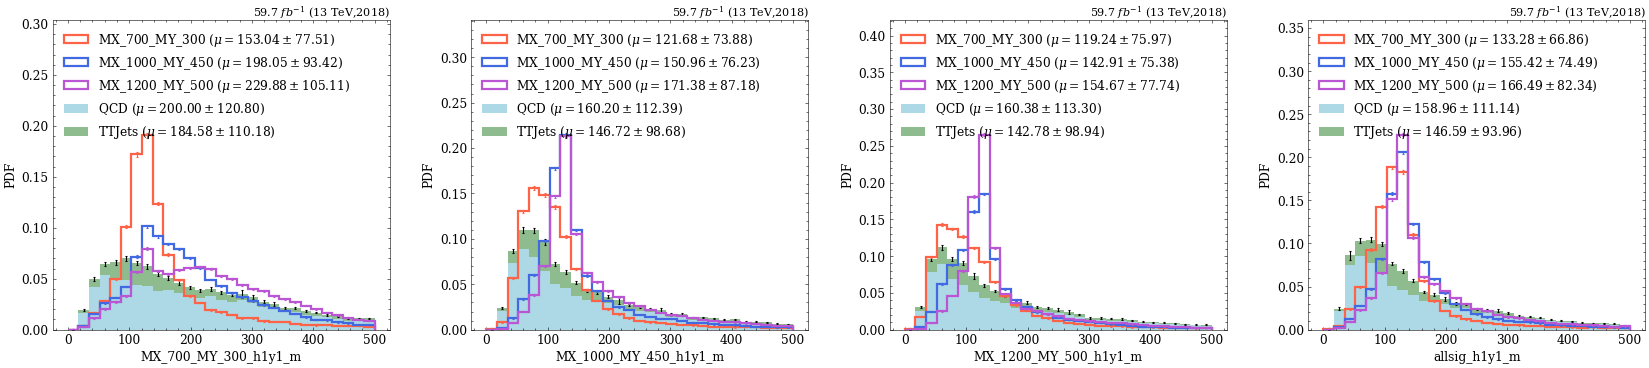

In [42]:
study.quick(
    signal+bkg,
    legend=True,
    varlist=[f'{mass}_h1y1_m' for mass in masslist],
    binlist=[(0,500,30)]*10,
    h_label_stat='$\mu={stats.mean:0.2f}\pm{stats.stdv:0.2f}$',
    efficiency=True,
    dim=-1,
)

100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


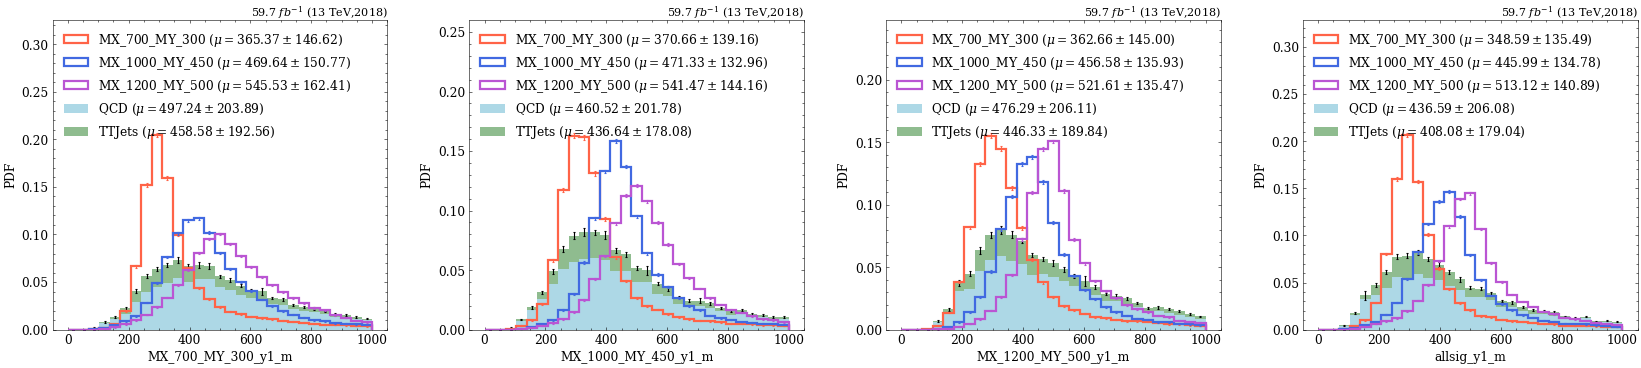

In [43]:
study.quick(
    signal+bkg,
    legend=True,
    varlist=[f'{mass}_y1_m' for mass in masslist],
    binlist=[(0,1000,30)]*10,
    h_label_stat='$\mu={stats.mean:0.2f}\pm{stats.stdv:0.2f}$',
    efficiency=True,
    dim=-1,
)

100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


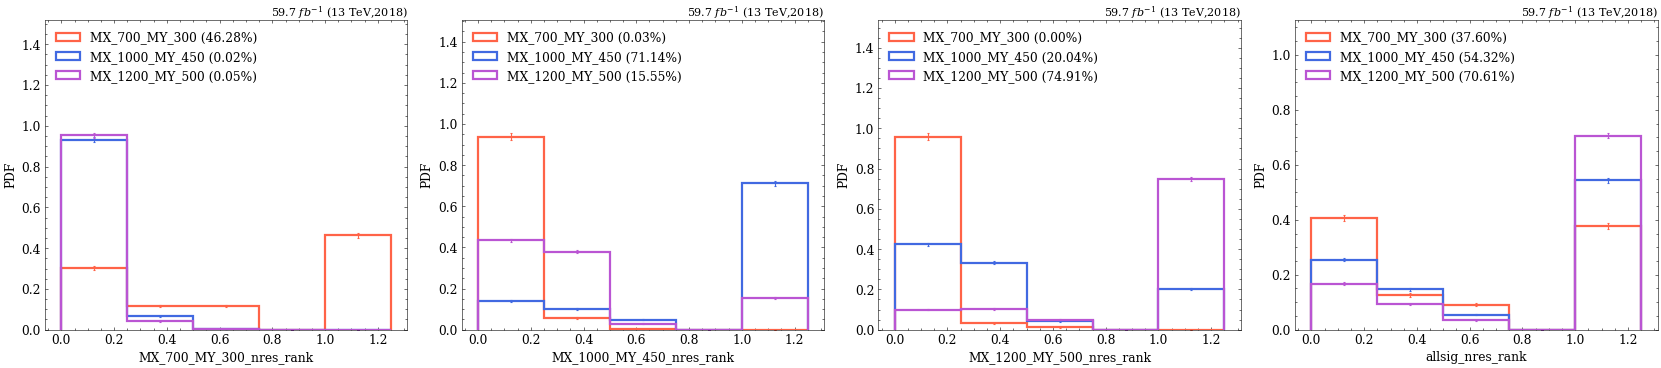

In [44]:
study.quick(
    signal,
    masks=lambda t:t.nfound_select==8,
    legend=True,
    varlist=[f'{mass}_nres_rank' for mass in masslist],
    binlist=[np.arange(6)/4]*10,
    efficiency=True, 
    # log=True,
    h_label_stat=lambda h:f'{h.histo[-1]:0.2%}',
    dim=-1,
)

100%|██████████| 8/8 [00:01<00:00,  5.29it/s]


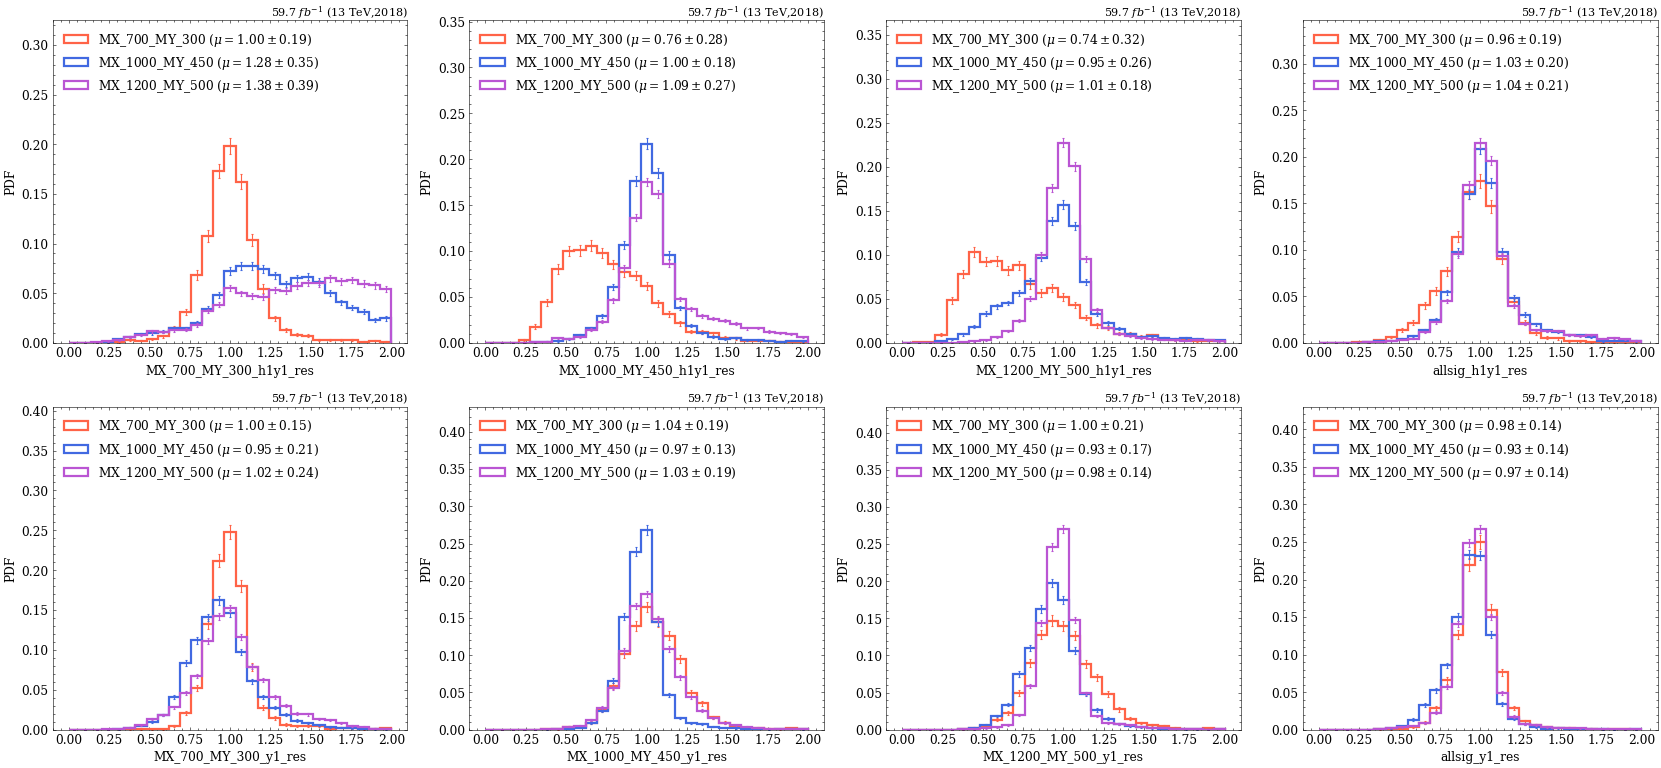

In [46]:
study.quick(
    signal,
    masks=lambda t:t.nfound_select==8,
    legend=True,
    # varlist=[f'{mass}_{res}_m' for res in ('h1y1','y1') for mass in masslist],
    # binlist=[(0,500,30)]*len(masslist) + [(0,1000,30)]*len(masslist),
    varlist=[f'{mass}_{res}_res' for res in ('h1y1','y1') for mass in masslist],
    binlist=[(0,2,30)]*10,
    h_label_stat='$\mu={stats.mean:0.2f}\pm{stats.stdv:0.2f}$',
    efficiency=True,
    dim=(-1,len(masslist)),
)